In [114]:
from scipy import misc
from scipy.signal import convolve2d, wiener
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pywt
import matplotlib as mpl 
import math
mpl.rcParams['figure.figsize']=(5.0,5.0)    #(6.0,4.0)



def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def loadimg(path):
    return np.asarray(misc.imread(path, flatten=True, mode='F'))/255.

def mse(i1,i2):
    return np.mean( (i1 - i2) ** 2 )

def psnr(img1, img2):
    MSE = mse(img1,img2)
    if MSE < 6.502500000000001e-06:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(MSE))

def mod2(H):
    return H*np.conjugate(H)


## Simple Inversion

#### Exercise 1.1
In this exercise we will first blur out the image *Cameraman* using a circular blur filter of radius 4 and then we will restore it using the pseudo inverse of the filter.


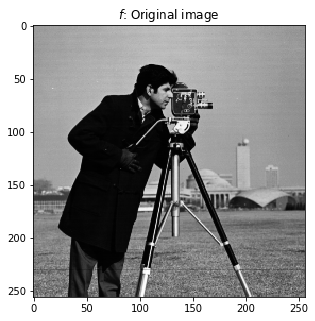

In [115]:
f = loadimg('Cameraman.bmp')

plt.title("$f$: Original image")
plt.imshow(f, cmap='gray')
plt.show()


In [116]:
h = [[0.0000,0.0000,0.0010,0.0072,0.0097,0.0072,0.0010,0.0000,0.0000],
     [0.0000,0.0041,0.0179,0.0199,0.0199,0.0199,0.0179,0.0041,0.0000],
     [0.0010,0.0179,0.0199,0.0199,0.0199,0.0199,0.0199,0.0179,0.0010],
     [0.0072,0.0199,0.0199,0.0199,0.0199,0.0199,0.0199,0.0199,0.0072],
     [0.0097,0.0199,0.0199,0.0199,0.0199,0.0199,0.0199,0.0199,0.0097],
     [0.0072,0.0199,0.0199,0.0199,0.0199,0.0199,0.0199,0.0199,0.0072],
     [0.0010,0.0179,0.0199,0.0199,0.0199,0.0199,0.0199,0.0179,0.0010],
     [0.0000,0.0041,0.0179,0.0199,0.0199,0.0199,0.0179,0.0041,0.0000],
     [0.0000,0.0000,0.0010,0.0072,0.0097,0.0072,0.0010,0.0000,0.0000]]
h = h/np.sum(h)

In [117]:
H = np.fft.fft2(h, f.shape)


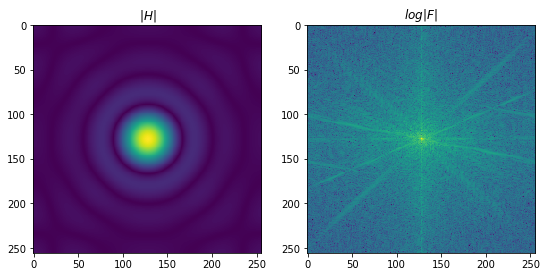

In [118]:
mpl.rcParams['figure.figsize']=(9.0,6.0)    #(6.0,4.0)


F = np.fft.fft2(f)
plt.subplot(121)
plt.imshow(np.abs(np.fft.fftshift(H)))
plt.title("$|H|$")
plt.subplot(122)
plt.title("$log|F|$")
plt.imshow(np.log(np.abs(np.fft.fftshift(F))))
plt.show()


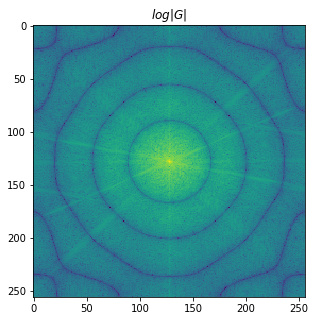

In [119]:
mpl.rcParams['figure.figsize']=(5.0,5.0)    #(6.0,4.0)


G = H*F
plt.imshow(np.log(np.abs(np.fft.fftshift(G))))
plt.title("$log|G|$")
plt.show()

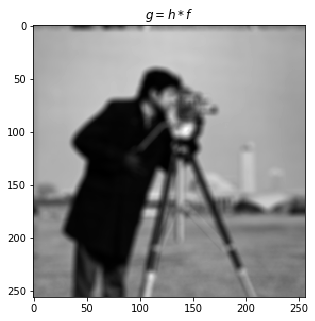

In [120]:
g = np.real(np.fft.ifft2(G))
plt.imshow(g, cmap='gray')
plt.title("$g=h*f$")
plt.show()

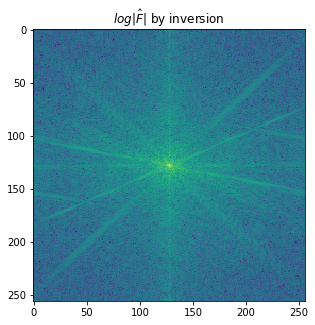

In [121]:
F_rec = G/H
plt.imshow(np.log(np.abs(np.fft.fftshift(F_rec))))
plt.title("$log|\hat{F}|$ by inversion")
plt.show()

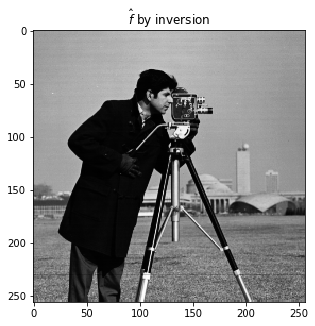

In [122]:
f_rec = np.real(np.fft.ifft2(F_rec))
plt.title("$\hat{f}$ by inversion")
plt.imshow(f_rec, cmap='gray')
plt.show()

In [123]:
error = mse(f_rec, f)
print("MSE: {:0.2e}".format(error))

MSE: 5.39e-33


Using the inversion in this simple case where the $f$ image is only modified by the filter $h$, $g=h*f$, is very effective and the reconstruction is perfect.  

#### Exercise 1.2

In this exercise however we will add some small gaussian noise $z$ to $g$, the resulting PSNR is 40dB, meaning that the noise is really small compared to the origianl image ($\sigma^2_{noise}=0.01$) and it is not visible (at least for me).

PSNR: 40.01dB


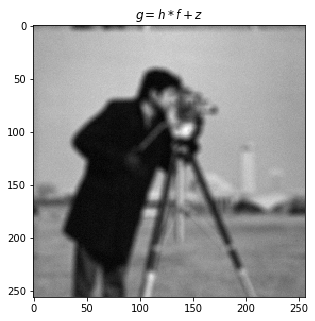

In [124]:
n = np.random.normal(0,1e-2, g.shape)
g1 = g + n
print("PSNR: {:0.2f}dB".format(psnr(g,g1)))
plt.imshow(g1, cmap='gray')
plt.title("$g = h*f+z$")
plt.show()

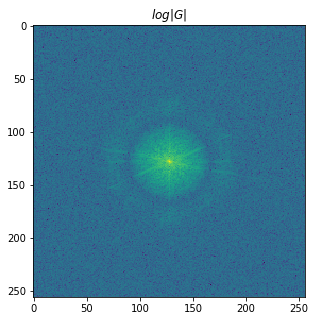

In [125]:
G1 = np.fft.fft2(g1)
plt.imshow(np.log(np.abs(np.fft.fftshift(G1))))
plt.title("$log|G|$")
plt.show()

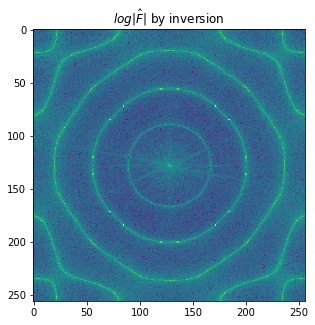

In [126]:
F_rec1 = G1/H
plt.imshow(np.log(np.abs(np.fft.fftshift(F_rec1))))
plt.title("$log|\hat{F}|$ by inversion")
plt.show()

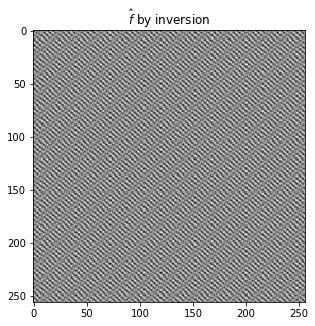

In [127]:
f_rec1 = np.real(np.fft.ifft2(F_rec1))
plt.imshow(f_rec1, cmap='gray')
plt.title("$\hat{f}$ by inversion")
plt.show()

The result of the reconstruction is totally wrong, even with such small noise. This is due the fact the $H$ has many singular point (where its value is very close or equal to 0), as the noise is equally distributed in the frequency domain when recostructing the image the noise present in the singular point of the filter is amplified of many order of magnetudes. This amplification is very well visible in the plot of $log(|\hat{F}|)$.

#### Exercise 1.3

To avoid the noise explosion a simple solution is to treshold the filter $H$ to bigger values:


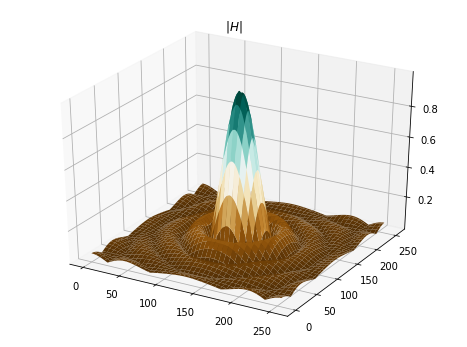

In [202]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)

X = np.arange(0, 256, 1)
Y = np.arange(0, 256, 1)

X, Y = np.meshgrid(X, Y)
ax.plot_surface(X,Y,np.abs(np.fft.fftshift(H)), cmap='BrBG')
plt.title('$|H|$')
plt.show()


To begin I start to tresholding all values of $H$ smaller than 0.1:

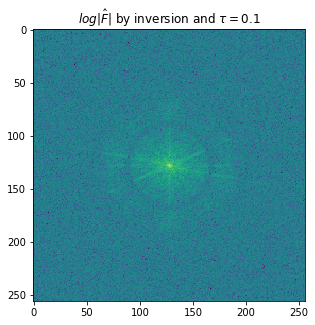

In [129]:
def treshold(H, t):
    H1 = H.copy()
    H1[np.abs(H1)<t] = t
    return H1
mpl.rcParams['figure.figsize']=(5.0,5.0)    #(6.0,4.0)

H1 = treshold(H, 1e-1)

F_rec2 = G1/H1
plt.imshow(np.log(np.abs(np.fft.fftshift(F_rec2))))
plt.title(r"$log|\hat{F}|$ by inversion and $\tau=0.1$")
plt.show()

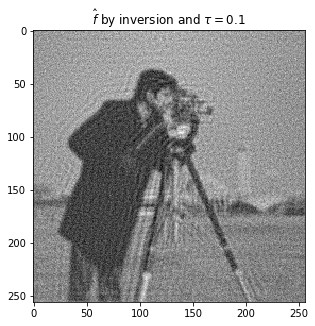

MSE: 1.45e-02


In [130]:
f_rec2 = np.real(np.fft.ifft2(F_rec2))
plt.imshow(f_rec2, cmap='gray')
plt.title(r"$\hat{f}$ by inversion and $\tau=0.1$")
plt.show()
print("MSE: {:0.2e}".format(mse(f_rec2, f)))

As it possible to see the reconstruction is already much better than the noise pattern of before, however I tried different configuration of the treshold $\tau$ to see what was the best one:

T optimal: 0.27 - 8.9e-03


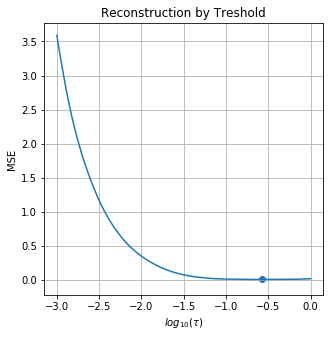

In [131]:
ts = np.logspace(-3,0,200)
mses = []
for t in ts:
    Hr = treshold(H,t)
    Fr = G1/Hr
    fr = np.real(np.fft.ifft2(Fr))
    mses.append(mse(fr,f))
mses_min = np.min(mses)
t_min = ts[np.argmin(mses)]
print("T optimal: {:0.2f} - {:0.1e}".format(t_min, mses_min))
plt.plot(np.log10(ts), mses)
plt.scatter(np.log10(t_min), mses_min)
plt.grid(True)
plt.title("Reconstruction by Treshold")

plt.xlabel(r'$log_{10}(\tau)$')
plt.ylabel('MSE')
plt.show()

The optimal treshold seems to be $\tau=0.27$ with an *mse* of only $8.9e^{-3}$ this the result reconstruction:

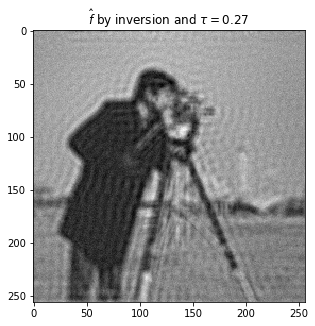

MSE: 8.87e-03


In [132]:

H1 = treshold(H, t_min)

F_rec2 = G1/H1

f_rec2 = np.real(np.fft.ifft2(F_rec2))
plt.imshow(f_rec2, cmap='gray')
plt.title(r"$\hat{f}$ by inversion and $\tau=0.27$")
plt.show()
print("MSE: {:0.2e}".format(mse(f_rec2, f)))

Even if the *mse* is smaller I still prefer the reconstruction with $\tau=0.27$.

## Regularization

Another simple way to avoid the noise amplification is to regularize the filter $H$ by adding some small value $\lambda$ that avoid (too) small values:

$$H_{\lambda} = \frac{H^*}{|H|^2+\lambda^2}$$

Note that $H_{\lambda}$ is already inverted respect to $H$.

My first experiment is again with $\lambda=0.1$:

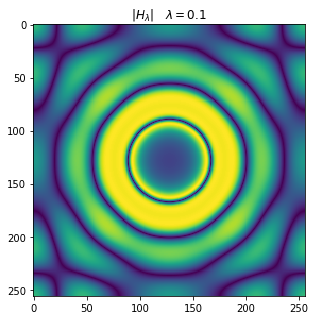

In [133]:
def regularization(H, lamb):
    return np.conjugate(H)/(mod2(H)+lamb**2)

lamb = 1e-1
H2 = regularization(H, lamb)

plt.title("$|H_{\lambda}|\quad\lambda=0.1$")
plt.imshow((np.abs(np.fft.fftshift(H2))))
plt.show()

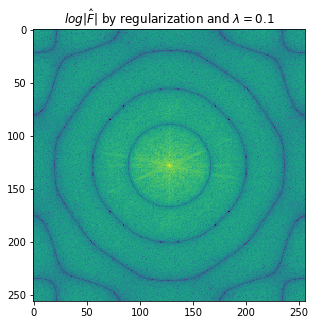

In [134]:
F_rec3 = G1*H2

plt.imshow(np.log(np.abs(np.fft.fftshift(F_rec3))))
plt.title(r"$log|\hat{F}|$ by regularization and $\lambda=0.1$")

plt.show()

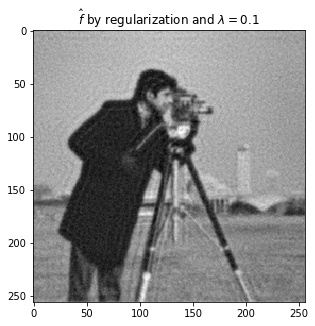

In [135]:
frec3 = np.real(np.fft.ifft2(F_rec3))
plt.title(r"$\hat{f}$ by regularization and $\lambda=0.1$")
plt.imshow(frec3, cmap="gray")
plt.show()


As before I looked which $\lambda$ minimize the error:

Lambda optimal: 0.10 - 3.9e-03


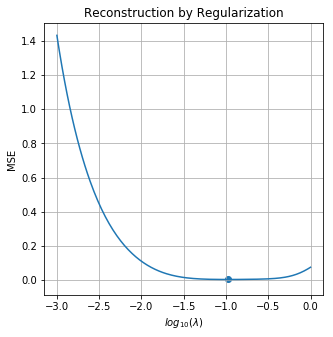

In [136]:
lambdas = np.logspace(-3,0,200)
mses = []
for lamb in lambdas:
    Hr = regularization(H,lamb)
    Fr = G1*Hr
    fr = np.real(np.fft.ifft2(Fr))
    mses.append(mse(fr,f))
lamb_min = lambdas[np.argmin(mses)]
mses_min = np.min(mses)
print("Lambda optimal: {:0.2f} - {:0.1e}".format(lamb_min, mses_min))

plt.plot(np.log10(lambdas), mses)
plt.scatter(np.log10(lamb_min), mses_min)
plt.grid(True)
plt.xlabel('$log_{10}(\lambda)$')
plt.ylabel('MSE')
plt.title("Reconstruction by Regularization")
plt.show()

In this case appear that $\lambda=0.1$ is already the best solution with an *mse* of only $3.9e^{-3}$, while the best reconstruction by treshold was capable to optain $8.91e^{-3}$, more or less the double. As well the visual reconstruction is much more pleasant.

## The Wiener Filter

The Wiener filter use some prior information, so is a statistical approach, on the signal to reconstruct it in such way to minimize the *mse*.
In particular it use the hypotetical power spectrum of noise ($S_z$) and signal ($S_f$) to do such reconstruction:
$$\hat{F}=\frac{H^*}{|H|^2+S_z/S_f}G$$
I recall that $|H|^2 = H\cdot H^*$ and the block $\frac{|H|^2}{H}$ as been replaced by only $H^*$.
#### Exercise 3.1
By using the real power spectrum of the signal and of the noise the result is the following:

In [167]:
def powerS(image):
    return mod2(np.fft.fft2(image))

def weiner(G, H, Sn, Sf):
    return (np.conjugate(H)/(mod2(H)+Sn/Sf))*G

Sn = powerS(n)
Sf = powerS(f)
Frec = weiner(G1, H, Sn, Sf)

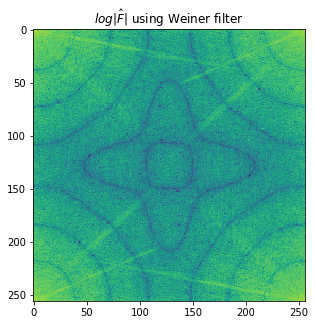

In [168]:
plt.imshow(np.log(np.abs(Frec)))
plt.title(r"$log|\hat{F}|$ using Weiner filter")
plt.show()



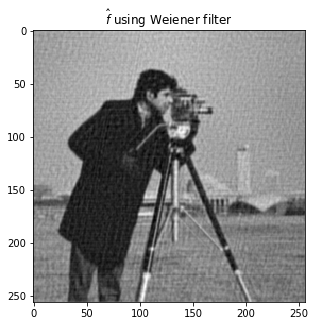

MSE: 2.7e-03


In [169]:
frec = np.real(np.fft.ifft2(Frec))
plt.imshow(frec, cmap='gray')
plt.title(r"$\hat{f}$ using Weiener filter")

plt.show()
print("MSE: {:0.1e}".format(mse(frec, f)))


The resulting reconstruction is slightly better than using the regularization.
However we used the original image to obtain such reconstruction, and in real application we don't have access to this information, but it's possible to use the power spectrum of another natural image (as most of real images have similar spectrum) to do such reconstruction: 

In [140]:
house = loadimg('TP5_images/house.tif')
Sn = powerS(n)
Sf = powerS(house)
Frec = weiner(G1, H, Sn, Sf)

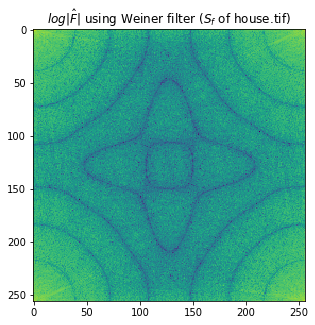

In [141]:
plt.imshow(np.log(np.abs(Frec)))
plt.title(r"$log|\hat{F}|$ using Weiner filter ($S_f$ of house.tif)")

plt.show()



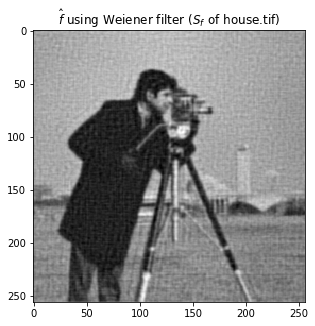

MSE: 3.5e-03


In [155]:
frec = np.real(np.fft.ifft2(Frec))
plt.imshow(frec, cmap='gray')
plt.title(r"$\hat{f}$ using Weiener filter ($S_f$ of house.tif)")
plt.show()
print("MSE: {:0.1e}".format(mse(frec, f)))


Even in this case the reconstruction is slightly better then using a simple regularization. The lost of performance against using the original $S_f$ are around ~30%.
Then I try to use the wiener filter implemented in the *skimage* python package, this implementation doesn't ask for any prior $S_f$ or $S_n$ so I suppose is some how coded or extracted from $G$ directly:

In [156]:
from skimage import color, data, restoration
fscipy =  np.real(restoration.wiener(g,psf=H,balance=1e-4, is_real=False))

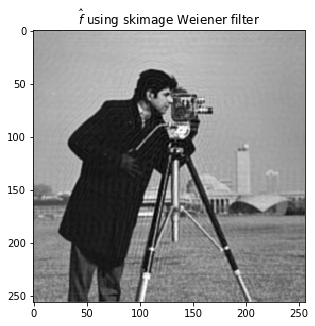

MSE: 1.1e-03


In [166]:
plt.imshow(fscipy, cmap='gray')
plt.title(r"$\hat{f}$ using skimage Weiener filter")
plt.show()
print("MSE: {:0.1e}".format(mse(fscipy, f)))



The result of such reconstruction is even better then the previous ones (~3 times better than using the origianl $S_f$). After a quick look at their code to understand what is difference, their implementation is very close to our:
```python
wiener_filter = np.conj(H) / (np.abs(H) ** 2 + balance * np.abs(reg) ** 2)
return uft.uifft2(wiener_filter * uft.ufft2(image))
```
Where ```reg``` replace our $S_z/S_f$ and is computed using a laplacian filter (second derivate of the image):
```python
reg, _ = uft.laplacian(image.ndim, image.shape, is_real=is_real)
```
and the ```balance``` constant is a constant to improve the balance between the data adaquacy and the restoration. 
The results is:
$$\hat{F} = \frac{H^*}{|H|^2+\lambda|LG|^2}G$$


#### Exercise 3.2

Another way to compute the $S_f$ without having access to the original image is to compute it from the noisy image itself:

$$r=\sigma^2_f \rho^{-\sqrt{x^2+y^2}}+\mu_f$$
where $\sigma_f^2$ is the variance of the image and $\mu_f$ its mean. While $\rho$ is the local correlation:



In [257]:
def rxy(g):

    var = np.var(g)
    mu = np.average(g)

    gh = np.roll(g,1, axis=0)
    gv = np.roll(g,-1, axis=1)
    gv = gv.reshape(1,g.size)
    gh = g1.reshape(gv.shape)
    rho = np.corrcoef(gv,gh)[0,1]


    print("var : {:0.2e}".format(var))
    print("mu  : {:0.2e}".format(mu))
    print("rho : {:0.2e}".format(rho))
    w = g.shape[0]
    h = g.shape[1]
    cx = w/2
    cy = h/2
    r = np.zeros(g.shape)
    
    for x in range(w):
        x1 = x-cx
        for y in range(h):
            y1 = y-cy
            r[x,y] = var*rho**(-np.sqrt(x1**2+y1**2))+mu
    return r


var : 4.92e-02
mu  : 4.66e-01
rho : 9.82e-01


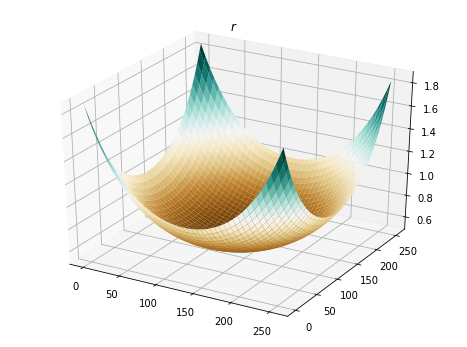

In [258]:
r = rxy(g)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)

X = np.arange(0, 256, 1)
Y = np.arange(0, 256, 1)

X, Y = np.meshgrid(X, Y)
ax.plot_surface(X,Y,r, cmap='BrBG')
plt.title('$r$')
plt.show()


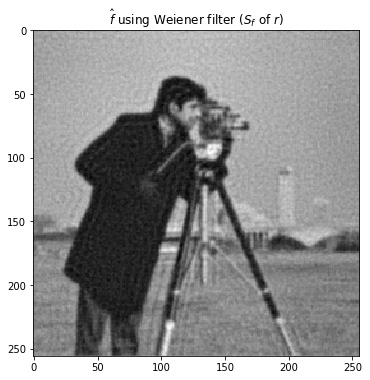

MSE: 3.7e-03


In [277]:
Frec = weiner(G1, H, 1e-2,r)
frec = np.real(np.fft.ifft2(Frec))
plt.imshow(frec, cmap='gray')
plt.title(r"$\hat{f}$ using Weiener filter ($S_f$ of $r$)")
plt.show()
print("MSE: {:0.1e}".format(mse(frec, f)))


The resulting reconstrution has *mse* (and visual result) very similar to the reconstruction with $S_f$ from a different image.